<font size="+4">`Signal and Audio Processing`</font>

<font size="+3">`Seminar 01: Introduction to Signals. Discrete Fourier Transform`</font>

<font size="+2">`Maks Nakhodnov & Dmitry Kropotov`</font>

<font size="+2">`Bremen, 2026`</font>

What you will learn from this notebook:
*   **The Nature of Signals:** The difference between analog, discrete, and digital signals; how quantization works and how to evaluate its quality.
*   **Mathematical Foundations:** Signals as vectors in a Hilbert space, orthonormal bases.
*   **Discrete Fourier Transform (DFT):** Decomposing a signal into frequencies, the Fast Fourier Transform (FFT).
*   **Physical Meaning of the Spectrum:** What frequency bins are, and why resolution depends on the recording duration ($T$), not the sampling rate ($F_s$).
*   **Aliasing and the Sampling Theorem:** Why false frequencies appear, what the Nyquist frequency is, and why the spectrum of a real-valued signal is symmetric.

In [1]:
import os
import sys
import time
from functools import partial

import numpy as np
import scipy as sc
import pandas as pd

import sounddevice as sd

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

import plotly.graph_objects as go

from ipywidgets import interact
from IPython.display import Audio, HTML

import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# `Signals and Mathematical Foundations`

<b style='color:red;'>What is a signal? Why do we need it? How do we process it?</b>

<details><summary>Answer:</summary>>> A signal is a formal description of a phenomenon evolving in time.</details>

An example of a signal is the dependence of room temperature on time.

<b style='color:red;'>What characterizes a signal?</b>
<details><summary>Answer:</summary> In the simplest case — its amplitude at each moment in time. </details>

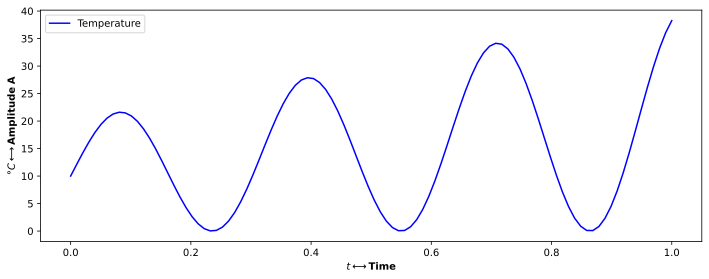

In [2]:
xs = np.linspace(0.0, 1.0, 100)
ys = 10 * (xs + 1.0) * (np.sin(20 * xs) + 1.0)

fig, ax = plt.subplots(1, 1, figsize=(10, 4))

ax.plot(xs, ys, color='blue', label='Temperature')

ax.set_xlabel(r'$t \longleftrightarrow \bf{Time}$')
ax.set_ylabel(r'$\degree C \longleftrightarrow \bf{Amplitude}\;A$')
ax.legend()
plt.tight_layout()
plt.show()

## `Types of Signals`

There are 3 main types of signals:
1. **Analog** — defined on a continuous interval, e.g., $\mathbb{R}$, and can take arbitrary values at any moment, usually $\mathbb{R}$ or $\mathbb{C}$:
$$
s(t): \mathcal{T} \longrightarrow \mathcal{A}
$$

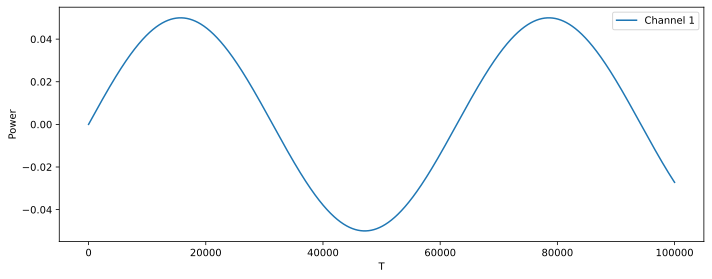

In [3]:
analog_signal = lambda t: np.sin(1 * t) / 20

display(Audio(data=analog_signal(np.linspace(0.0, 10.0, 100000)), rate=44100, normalize=False))

fig, ax = plt.subplots(1, 1, figsize=(10, 4))

ax.plot(analog_signal(np.linspace(0.0, 10.0, 100000)), label='Channel 1')

ax.legend()
ax.set_xlabel('T')
ax.set_ylabel('Power')
fig.tight_layout()
plt.show()

<b style='color:red;'>Why can't we hear anything? We created a signal, didn't we?</b>
<details><summary>Answer:</summary>
In sound, the frequency of oscillation matters, not just the absolute pressure!
</details>

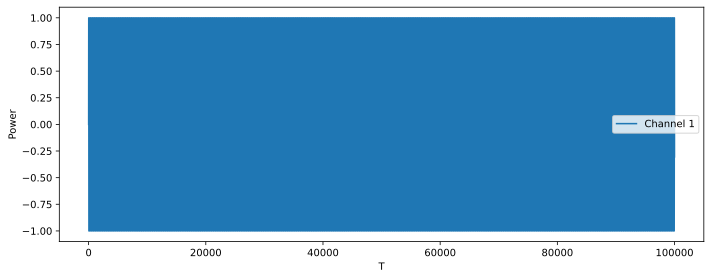

In [4]:
analog_signal = lambda t: np.sin(1000 * t)

display(Audio(data=analog_signal(np.linspace(0.0, 10.0, 100000)), rate=44100, normalize=False))

fig, ax = plt.subplots(1, 1, figsize=(10, 4))

ax.plot(analog_signal(np.linspace(0.0, 10.0, 100000)), label='Channel 1')

ax.legend()
ax.set_xlabel('T')
ax.set_ylabel('Power')
fig.tight_layout()
plt.show()

2. **Discrete** — defined on a discrete set, e.g., $\mathbb{N}$ or $\mathbb{Z}$, and can take arbitrary values at any moment.

Usually, a discrete signal is defined as a sequence, via samples of a continuous-time signal $s(t)$:

$$
s[n] = s(t_{n}),\;\text{where a uniform grid is typically used:}\;s[n] = s(n \Delta t)
$$

This representation allows extending discrete signals to analog ones:
$$
s_{d}(t) = s(t) * ш_{T}(t),\;\text{where}\;ш_{T}(t)\;\text{is the Dirac comb (lattice function) defining the time samples}
$$

For a uniform grid on $\mathbb{R}$, the following representation of the Dirac comb holds, which will be useful later:
$$
ш_{T}(t) = \sum\limits_{n=-\infty}^{\infty} \delta(t - n\Delta t) \Rightarrow s_{d}(t) = \sum\limits_{n=-\infty}^{\infty} s(t)\delta(t - n\Delta t)
$$

*This transformation defines **ideal sampling** of the signal $s(t)$. In the real world, ideal sampling does not exist; instead, an approximation of the Dirac comb is used, but we will not account for this in the current course.*

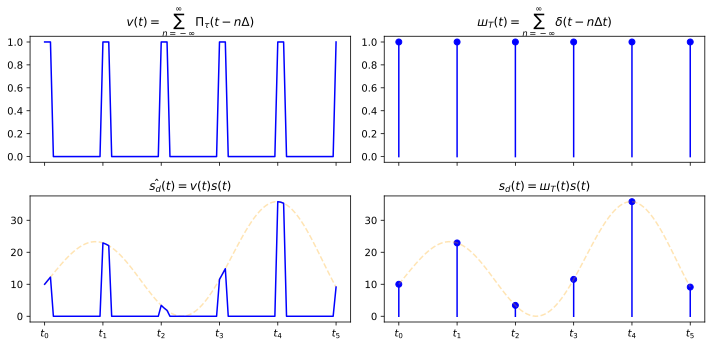

In [5]:
xs = np.linspace(0.0, 1.0, 101)
ys = 10 * (xs + 1.0) * (np.sin(10 * xs) + 1.0)

uus = xs * 100 % 20 < 3

fig, axes = plt.subplots(2, 2, figsize=(10, 5), sharex=True, sharey=False)

axes[0, 0].plot(xs, uus, color='blue')
for x, y in zip(xs[::20], ys[::20]):
    axes[0, 1].plot([x, x], [0, 1], color='blue')
    axes[0, 1].scatter([x], [1], color='blue')

    axes[1, 1].plot([x, x], [0, y], color='blue')
    axes[1, 1].scatter([x], [y], color='blue')

axes[0, 0].set_xticks(xs[::20])
axes[0, 1].set_xticks(xs[::20])
axes[0, 0].set_xticklabels([f'$t_{idx}$' for idx in range(len(xs[::20]))])
axes[0, 1].set_xticklabels([f'$t_{idx}$' for idx in range(len(xs[::20]))])

axes[1, 0].plot(xs, ys, '--', color='orange', alpha=0.3)
axes[1, 1].plot(xs, ys, '--', color='orange', alpha=0.3)
axes[1, 0].plot(xs, ys * uus, color='blue')

axes[0, 0].set_title(r'$v(t) = \sum_{n=-\infty}^{\infty} \Pi_{\tau}(t - n\Delta)$')
axes[0, 1].set_title(r'$ш_{T}(t) = \sum_{n=-\infty}^{\infty} \delta(t - n\Delta t)$')
axes[1, 0].set_title(r'$\hat{s_{d}}(t) = v(t)s(t)$')
axes[1, 1].set_title(r'$s_{d}(t) = ш_{T}(t)s(t)$')


fig.tight_layout()
plt.show()

<b style='color:red;'>Do we lose information when moving from an analog signal to a discrete one? The answer is given by the Kotelnikov (Nyquist-Shannon) Sampling Theorem!</b>

3. **Digital** — defined on a discrete set, e.g., $\mathbb{N}_{+}$, and values are also taken from a discrete set.

The procedure of transitioning from a discrete signal to a digital one is called **quantization** — partitioning the magnitude values into a finite number of intervals.

<b style='color:red;'>For example, $s(t) \in [0, 1]$. How do we optimally represent the signal values in a computer as a number (i.e., 4 bits)?</b>
<details><summary>Answer:</summary>
<ul>
<li>Uniform coding, $16$ intervals: $[\frac{i}{16}, \frac{i+1}{16})$.</li>
<li>Non-uniform coding, if values are distributed substantially non-uniformly.</li>
</ul>
</details>

Let's look at a real digital signal:

In [6]:
# Sampling rate (standard is 44100 Hz) and Recording duration in seconds
sample_rate, seconds = 44100, 2 

digital_signal = sd.rec(int(sample_rate * seconds), samplerate=sample_rate, channels=1)
sd.wait()

Audio(data=digital_signal[:, 0], rate=sample_rate)

float32 True


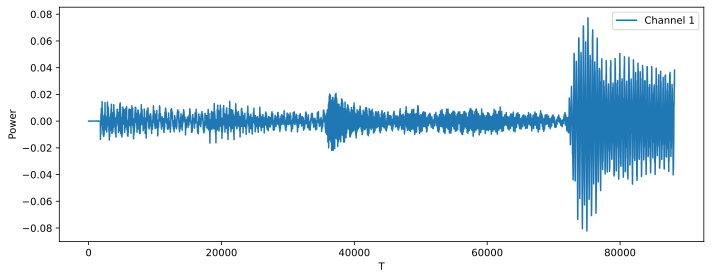

In [7]:
print(digital_signal.dtype, digital_signal.shape[0] == sample_rate * seconds)

fig, ax = plt.subplots(1, 1, figsize=(10, 4))

ax.plot(digital_signal[:, 0], label='Channel 1')

ax.legend()
ax.set_xlabel('T')
ax.set_ylabel('Power')
fig.tight_layout()
plt.show()

In this case, we recorded the signal value at $2 \times 44100 = 88200$ equidistant samples, i.e., every $1 / 44100$ second. Meanwhile, the signal value can be any real number, which effectively gives us $\approx 4 \times 10^9$ unique values.

### `Quantization`

Let's see how the signal changes with coarser discretization:

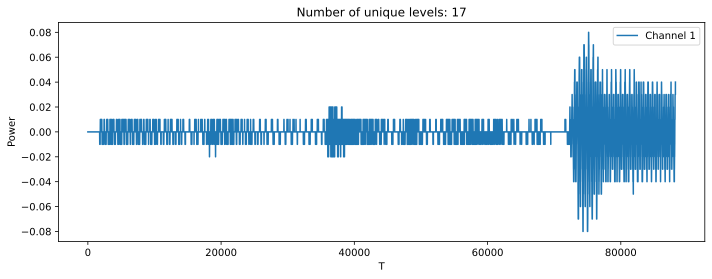

In [8]:
digital_coarse_signal = np.round(digital_signal, 2)

display(Audio(data=digital_coarse_signal[:, 0], rate=sample_rate))

fig, ax = plt.subplots(1, 1, figsize=(10, 4))

ax.plot(digital_coarse_signal[:, 0], label='Channel 1')

ax.legend()
ax.set_xlabel('T')
ax.set_ylabel('Power')

digital_coarse_signal_levels = np.unique(digital_coarse_signal)
ax.set_title('Number of unique levels: {0:d}'.format(len(digital_coarse_signal_levels)))
fig.tight_layout()
plt.show()

We kept only $10$ unique values, effectively quantizing it into $3.3$ bits.

However, for a specific signal, different discretization methods will lead to different approximation qualities. For example, one can iteratively improve quantization levels (essentially 1D KMeans):

In [9]:
def lloyd_max(signal, k, iters=10):
    # 1. Initialization (uniform in amplitude)
    levels = np.linspace(signal.min(), signal.max(), k)

    for i in range(iters):
        # 2. Find decision thresholds (boundaries between levels)
        thresholds = (levels[:-1] + levels[1:]) / 2

        # 3. Assign each signal value to a level index
        # np.digitize returns indices from 0 to k-1
        indices = np.digitize(signal, thresholds)

        # 4. Update levels (centroids)
        new_levels = np.zeros(k)
        for j in range(k):
            mask = (indices == j)
            if np.any(mask):
                new_levels[j] = signal[mask].mean()
            else:
                # If nothing falls into the level, keep the old one
                new_levels[j] = levels[j]

        # Ensure sorting for correct np.digitize behavior in the next iteration
        new_levels = np.sort(new_levels)

        # Convergence check
        if np.allclose(levels, new_levels, atol=1e-7):
            break
        levels = new_levels

    # Final quantization
    final_thresholds = (levels[:-1] + levels[1:]) / 2
    final_indices = np.digitize(signal, final_thresholds)
    quantized_signal = levels[final_indices]

    return quantized_signal, levels

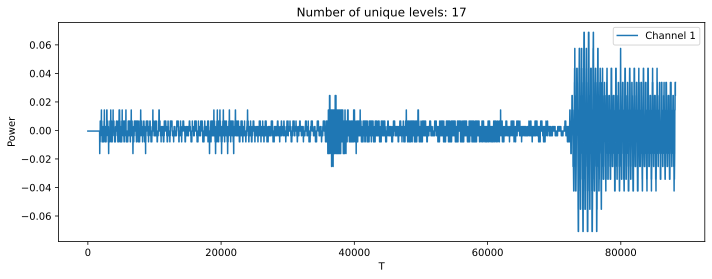

In [10]:
digital_lloyd_signal, levels = lloyd_max(digital_signal[:, 0], len(digital_coarse_signal_levels), iters=50)

display(Audio(data=digital_lloyd_signal, rate=sample_rate))

fig, ax = plt.subplots(1, 1, figsize=(10, 4))

ax.plot(digital_lloyd_signal, label='Channel 1')

ax.legend()
ax.set_xlabel('T')
ax.set_ylabel('Power')
digital_lloyd_signal_levels = np.unique(digital_lloyd_signal)
ax.set_title('Number of unique levels: {0:d}'.format(len(digital_lloyd_signal_levels)))
fig.tight_layout()
plt.show()

The new discretization turns out to be significantly better than the uniform one, almost by a factor of $3$!

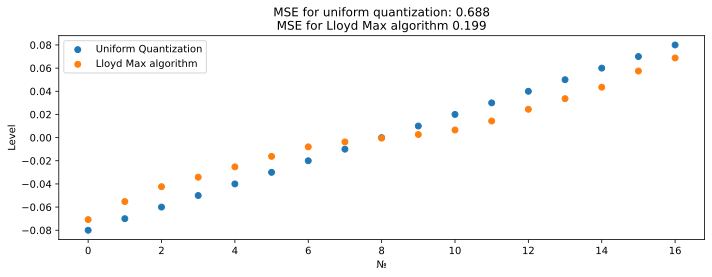

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

ax.scatter(np.arange(len(digital_coarse_signal_levels)), digital_coarse_signal_levels, label='Uniform Quantization')
ax.scatter(np.arange(len(digital_lloyd_signal_levels)), digital_lloyd_signal_levels, label='Lloyd Max algorithm')

ax.legend()
ax.set_xlabel('№')
ax.set_ylabel('Level')
ax.set_title(
    'MSE for uniform quantization: {0:.3f}\nMSE for Lloyd Max algorithm {1:.3f}'.format(
        np.sum((digital_signal - digital_coarse_signal) ** 2), 
        np.sum((digital_signal[:, 0] - digital_lloyd_signal) ** 2)
    )
)
fig.tight_layout()
plt.show()

### `Quality Metrics: SNR and the Decibel Scale`

We compared two quantization methods and saw that the MSE for Lloyd Max is lower. However, MSE alone says little if we don't know the scale of the signal itself.

For an objective assessment, we need to compare the **error power** with the **signal power**.

Let $s[n]$ be a discrete signal of length $N$.

*   **Signal Energy:**
    $$ E_s = \sum_{n=0}^{N-1} |s[n]|^2 $$

*   **Average Signal Power:**
    $$ P_s = \frac{1}{N} \sum_{n=0}^{N-1} |s[n]|^2 $$

To evaluate quality objectively, we compare the **power of the useful signal** to the **power of the noise** (in our case, the noise is the quantization error $e[n] = s[n] - s_q[n]$).

$$ \text{SNR} = \frac{P_{\text{signal}}}{P_{\text{noise}}} = \frac{\sum |s[n]|^2}{\sum |s[n] - s_q[n]|^2} $$

In signal processing, power ratios can be gigantic — a linear scale is inconvenient. Furthermore, human perception (hearing, vision) works logarithmically (see [Weber–Fechner law](https://en.wikipedia.org/wiki/Weber%E2%80%93Fechner_law)). Therefore, a logarithmic unit is used — the **Bel** (in honor of Alexander Graham Bell), and in practice — one-tenth of it, the **Decibel**.

The **Decibel** is a dimensionless logarithmic unit indicating the ratio of a physical quantity to a reference value.

* **For energy quantities (Power, Energy, Intensity):**
$$ L_{dB} = 10 \cdot \log_{10}\left( \frac{P}{P_{ref}} \right) $$

* **For field quantities (Amplitude, Voltage, Current):**
Since power is proportional to the square of amplitude ($P \sim A^2$), the multiplier doubles:
$$ L_{dB} = 10 \cdot \log_{10}\left( \frac{A^2}{A_{ref}^2} \right) = 20 \cdot \log_{10}\left( \frac{A}{A_{ref}} \right) $$

Consequently, for our SNR in decibels:
$$ \text{SNR}_{dB} = 10 \cdot \log_{10}\left( \frac{P_{\text{signal}}}{P_{\text{noise}}} \right) $$

**The "6 Bit" Rule (SQNR)**

To evaluate quantization, we can derive a relationship between bit depth and quality. Suppose the signal was quantized into $b$ bits.

Then, increasing the bit depth by 1 changes the number of levels from $2^b \to 2^{b+1}$. Note that the quantization step, and consequently the maximum error amplitude, decreases by a factor of two: $A_{\text{noise}_{\text{new}}}  \approx \frac{1}{2} A_{\text{noise}_{\text{old}}}$.

Substituting into the $\text{SNR}$ formula:
    $$ \Delta \text{SNR}_{dB} = 20 \cdot \log_{10}\left( \frac{A_{\text{noise}_{\text{old}}}}{A_{\text{noise}_{\text{new}}}} \right) \approx 20 \cdot 0.301 = 6.02 \text{dB} $$

We get an empirical rule: **each additional 1 bit of quantization adds $\approx 6$ dB to the signal quality.**

**Examples:**
*   **8 bit** (old telephony): $8 \times 6 = 48$ dB.
*   **16 bit** (Audio CD): $16 \times 6 = 96$ dB.

In [12]:
snr_db_coarse = 10 * np.log10(
    np.mean(digital_signal[:, 0] ** 2) / np.mean((digital_signal[:, 0] - digital_coarse_signal[:, 0]) ** 2)
)
snr_db_lloyd = 10 * np.log10(
    np.mean(digital_signal[:, 0] ** 2) / np.mean((digital_signal[:, 0] - digital_lloyd_signal) ** 2)
)

snr_db_coarse, snr_db_lloyd

(13.185712099075317, 18.567414880054695)

 That is, by using smart quantization, we "gained" $1$ bit of information, and our coding will be significantly more memory efficient.

### `Categorization of Discrete Signals`  

*In this course, we will mainly focus on discrete signals: discrete time and continuous amplitude.*

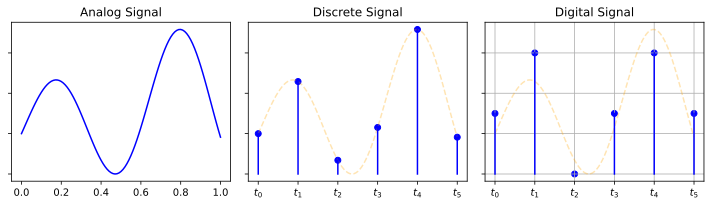

In [13]:
xs = np.linspace(0.0, 1.0, 101)
ys = 10 * (xs + 1.0) * (np.sin(10 * xs) + 1.0)

fig, axes = plt.subplots(1, 3, figsize=(10, 3))

axes[0].plot(xs, ys, color='blue')
axes[1].plot(xs, ys, '--', color='orange', alpha=0.3)
axes[2].plot(xs, ys, '--', color='orange', alpha=0.3)

for x, y in zip(xs[::20], ys[::20]):
    axes[1].plot([x, x], [0, y], color='blue')
    axes[2].plot([x, x], [0, np.round(y / 15) * 15], color='blue')
    axes[1].scatter([x], [y], color='blue')
    axes[2].scatter([x], [np.round(y / 15) * 15], color='blue')
axes[1].set_xticks(xs[::20])
axes[2].set_xticks(xs[::20])
axes[1].set_xticklabels([f'$t_{idx}$' for idx in range(len(xs[::20]))])
axes[2].set_xticklabels([f'$t_{idx}$' for idx in range(len(xs[::20]))])

axes[0].yaxis.set_ticklabels([])
axes[0].yaxis.set_ticklabels([])
axes[1].yaxis.set_ticklabels([])
axes[1].yaxis.set_ticklabels([])
axes[2].yaxis.set_ticklabels([])
axes[2].yaxis.set_ticklabels([])

axes[2].grid(True)

axes[0].set_title('Analog Signal')
axes[1].set_title('Discrete Signal')
axes[2].set_title('Digital Signal')

plt.tight_layout()
plt.show()

Discrete signals are usually divided into 3 classes:

1. **Finite**: $s[n], n \in \{0, ..., N - 1\}$
2. **Periodic**: $s[n] = s[n + kN],\;\forall\;k\in\mathbb{Z}$
3. **Aperiodic**: $s[n], n\in\mathbb{Z}$

Infinite signals can be obtained from finite ones naturally:

**Aperiodic** $\overset{\text{Zero-padding}}{\Longleftarrow}$ **Finite** $\overset{\text{Repetition}}{\Longrightarrow}$ **Periodic**

## `Signal Examples`

Let's analyze a few examples of discrete signals. Generally, we define a signal $s[n] \in \mathbb{C}, n \in \mathbb{Z}$.

1. **Impulse (Dirac delta)**:
$
\delta[n] = \begin{cases}
    1, &n = 0 \\
    0, &n \ne 0
\end{cases}
$

Useful for analyzing systems: we will watch how a system responds to such a signal. For example, if the system is a room. How does the room disperse an echo?

Impulse Response (RIR) — the reaction of a system to an input signal in the form of an infinitely short impulse.

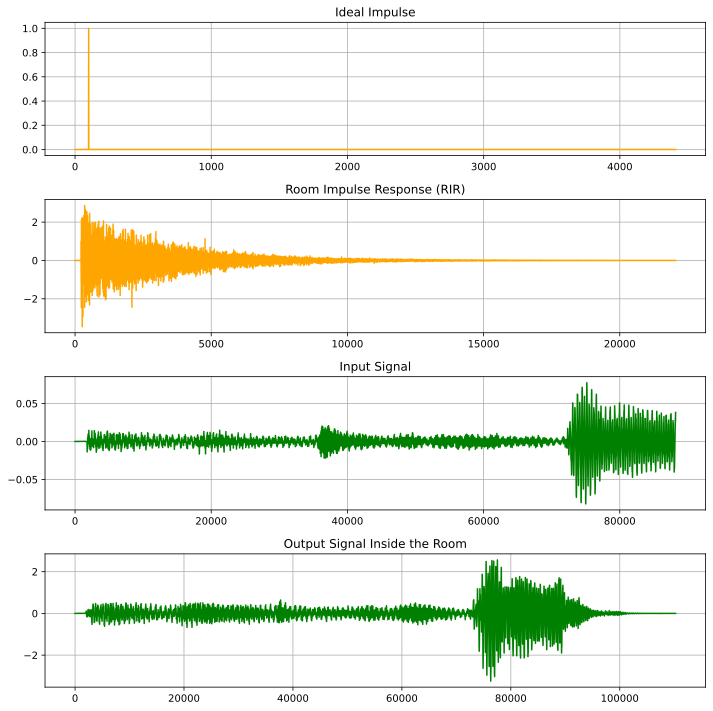

In [14]:
def create_room_impulse_response(duration=1.0, fs=44100, rt60=0.):
    """
    Generates a simplified room impulse response.
    rt60 - time for sound to decay by 60 dB (reverberation time).
    """
    t = np.linspace(0, duration, int(fs * duration))

    # 1. Generate random noise (reflections)
    noise = np.random.normal(0, 1, len(t))

    # 2. Create exponential decay envelope
    # Formula for decay: A = exp(-6.9 * t / RT60)
    envelope = np.exp(-6.91 * t / rt60)

    # 3. Model RIR: noise * envelope
    rir = noise * envelope

    # 4. Add "direct sound" (the strongest first peak)
    rir[0] = 1.0

    # Remove noise at the very beginning (simulating propagation delay)
    pre_delay = int(0.005 * fs) # 5 ms delay
    rir = np.concatenate([np.zeros(pre_delay), rir[:-pre_delay]])

    return rir

fs, duration = 44100, 1.5

# 1. Create impulse
impulse_input = np.zeros(int(fs * 0.1))
impulse_input[100] = 1.0

# 2. Model "Room"
room_ir = create_room_impulse_response(duration=0.5, fs=fs, rt60=0.5)

# 3. Pass signal through the system
output_signal = sc.signal.convolve(impulse_input, room_ir, mode='full')
output_digital_signal = sc.signal.convolve(digital_signal[:, 0], room_ir, mode='full')

fig, axes = plt.subplots(4, 1, figsize=(10, 10))

axes[0].plot(impulse_input, color='orange')
axes[1].plot(room_ir, color='orange')
axes[2].plot(digital_signal, color='green')
axes[3].plot(output_digital_signal, color='green')

axes[0].grid()
axes[1].grid()
axes[2].grid()
axes[3].grid()

axes[0].set_title("Ideal Impulse")
axes[1].set_title("Room Impulse Response (RIR)")
axes[2].set_title("Input Signal")
axes[3].set_title("Output Signal Inside the Room")

fig.tight_layout()
plt.show()

display(Audio(data=impulse_input, rate=fs))
display(Audio(data=room_ir, rate=fs))
display(Audio(data=digital_signal[:, 0], rate=sample_rate))
display(Audio(data=output_digital_signal, rate=fs))

2. **Step Function (Heaviside step)**:
$
u[n] = \begin{cases}
    1, &n \ge 0 \\
    0, &n < 0
\end{cases}
$

Example: suddenly switching on current in a system. Change in current $\Rightarrow$ alternating magnetic field $\Rightarrow$ alternating electric field $\Rightarrow$ How will the system behave?

![](https://electroandi.ru/images/posledovatelnaya-rl-tsep/posledovatelnaya-rl-tsep-1.jpg)

Consider a simple RL circuit. It can be described by the following differential equation:

$$L\frac{dI(t)}{dt} + RI(t) = U(t)$$

Let's assume we model switching on a fixed voltage $V$ in such a circuit.

At the initial moment, no current flows through the system: $U(0) = 0 \Rightarrow I(0) = 0$

Then, $L\frac{dI(t)}{dt} + RI(t) = V$ can be solved by considering the solution as a sum of the homogeneous:
$$
L\frac{dI(t)}{dt} + RI(t) = 0 \Longrightarrow I_{h}(t) = A \times e^{-\frac{R}{L}t}
$$

and for the inhomogeneous equation, a particular solution can be found:
$$
L\frac{dI(t)}{dt} + RI(t) = V \Longrightarrow \{\frac{dI(t)}{dt} = 0\} \Longrightarrow I_{p}(t) = \frac{V}{R}
$$

In total, considering the initial solution:
$$
I(t) = \frac{V}{R}(1 - e^{-\frac{R}{L}t}) \mathbb{1}[t >= 0]
$$

Thus, a step signal acting on an RL circuit system generates a current signal with exponential behavior.

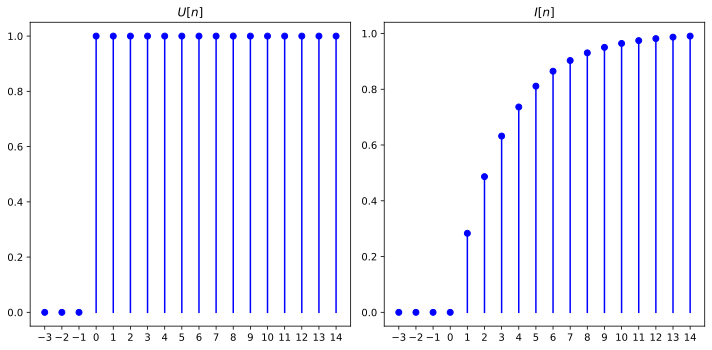

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

V, R, L = 1.0, 1.0, 3.0
for n in range(-3, 15):
    axes[0].plot([n, n], [0.0, 1.0 * (n >= 0)], color='blue')
    axes[0].scatter([n], [1.0 * (n >= 0)], color='blue')
    
    axes[1].plot([n, n], [0.0, V / R * (1 - np.exp(-R / L * n)) * (n >= 0)], color='blue')
    axes[1].scatter([n], [V / R * (1.0 - np.exp(-R / L * n)) * (n >= 0)], color='blue')

axes[0].set_xticks(range(-3, 15))
axes[1].set_xticks(range(-3, 15))
axes[0].set_title('$U[n]$')
axes[1].set_title('$I[n]$')
    
fig.tight_layout()
plt.show()

3. **Exponential Decay**: $s[n] = a^n u[n], a\in\mathbb{C}, |a|<1$

Example: law of radioactive decay: the rate of decay is proportional to the amount of substance. $\frac{dN}{dt} = -\lambda N \Rightarrow N(t) = N_{0}e^{-\lambda t}$.

4. **Complex Exponential**: $s[n] = e^{j (w_{0}n + \phi)} = cos(w_{0}n + \phi) + j sin(w_{0}n + \phi)$, where $j$ is the imaginary unit.

Example: current, voltage, resistance in AC systems.

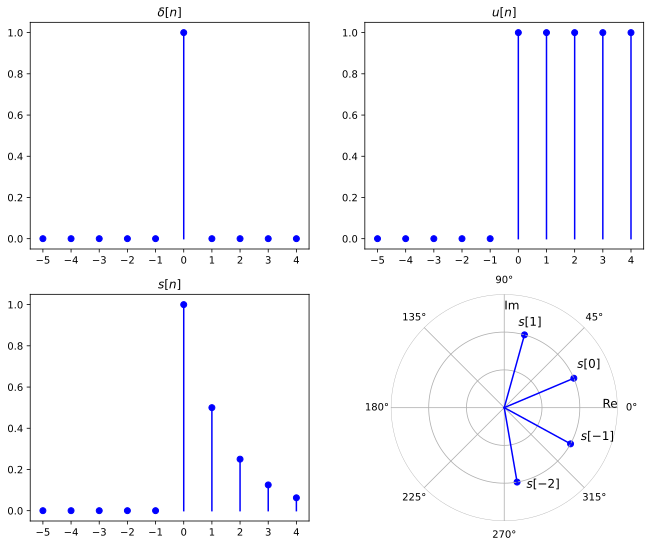

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(11, 9))
ax4_polar = fig.add_axes(axes[1, 1].get_position(), projection='polar', frameon=False)
axes[1, 1].set_axis_off()

for n in range(-5, 5):
    axes[0, 0].plot([n, n], [0.0, 1.0 * (n == 0)], color='blue')
    axes[0, 0].scatter([n], [1.0 * (n == 0)], color='blue')
    
    axes[0, 1].plot([n, n], [0.0, 1.0 * (n >= 0)], color='blue')
    axes[0, 1].scatter([n], [1.0 * (n >= 0)], color='blue')
    
    axes[1, 0].plot([n, n], [0.0, (0.5 ** n) * (n >= 0)], color='blue')
    axes[1, 0].scatter([n], [(0.5 ** n) * (n >= 0)], color='blue')

w_0, phi = 0.9, 0.4
for n in range(-2, 2):
    ax4_polar.plot([0, w_0 * n + phi], [0.0, 1.0], color='blue')
    ax4_polar.scatter([w_0 * n + phi], [1.0], color='blue')
    ax4_polar.annotate(f'$s[{n}]$', (w_0 * n + phi + 0.1, 1.1), fontsize=12)
    
axes[0, 0].set_xticks(range(-5, 5))
axes[0, 1].set_xticks(range(-5, 5))
axes[1, 0].set_xticks(range(-5, 5))
ax4_polar.set_yticks([0.0, 0.5, 1.0, 1.5])
ax4_polar.set_yticklabels(['', '', '', ''])

ax4_polar.annotate('Im', (np.pi / 2, 1.3), fontsize=12)
ax4_polar.annotate('Re', (0.0, 1.3), fontsize=12)

axes[0, 0].set_title(r'$\delta[n]$')
axes[0, 1].set_title(r'$u[n]$')
axes[1, 0].set_title(r'$s[n]$')

plt.show()

## `Signals as Elements of a Vector Space`

Representing a signal in the time domain is natural for human perception; however, from a technical point of view, physical signals are poorly suited for analysis in this representation:

1. **Transformation in LTI systems (Linear Time-Invariant).**
Most transformations that occur with signals in the real world can be described through the interaction of the signal with LTI systems. For example, sound propagation in an environment (room, amplifier, sound propagation medium). Such systems significantly change the appearance of the signal in its time representation. It turns out that representing the signal as a function **in another basis** significantly simplifies analysis.

2. **Complexity of operations on signals.**
The transformations from the previous point can be represented as convolution operations:

$$
s[n] \overset{\text{Effect of System H}}{\longrightarrow} y[n] = (s * h)[n] = \sum\limits_{k=0}^{N-1} s[k]h[n - k]
$$

Calculating this effect directly has complexity $\mathcal{O}(N^{2})$. However, switching to the **frequency basis** (under certain conditions!) allows reducing complexity to $\mathcal{O}(N\log N)$.

3. **Signal Compression.**
Since the time basis is not natural for real signals, storing such signals, as well as their effective lossless discretization, is impossible in the original basis. However, switching to the frequency space allows using a more compact representation.

To switch to another basis in signal representation, we need to define some vector properties of signals.

**Hilbert Space** — a linear, vector space with an inner product $\langle ., .\rangle$, complete relative to its metric.

The inner product defines a natural distance on the same space: $||x||^{2} = \langle x, x \rangle,\;\rho(x, y) = ||x - y||$

**Orthonormal Basis** — $\{b_{k}\}_{k=1}^{\infty} \subset V$:

$$
\forall\;g \in V\;\exists\{\alpha_k\}_{k=1}^{\infty}: g = \sum\limits_{k=1}^{\infty} \alpha_k b_k
$$
$$
\langle b_i, b_j\rangle = \delta_{ij} = \begin{cases}0, i\ne j \\ 1, i = j\end{cases}
$$

# `Fourier Series`

**Fourier Series [of element $g$ via system $\{b_{k}\}$]** — a formal expression of the form $\sum\limits_{k=1}^{\infty} \langle g, b_{k}\rangle b_{k} = \sum\limits_{k=1}^{\infty} g_{k} b_{k}$

To check that this system is a basis, it is necessary and sufficient to show that for any element $g \in V$, the Fourier series converges to $g$.

**Lemma 1.** Coefficients of partial sums of the Fourier Series provide the best approximation of element $g$:
$$
||g - \sum\limits_{k=1}^{n} c_{k} b_{k}||^{2} = \sum\limits_{k=1}^{n} (c_{k} - g_{k})^{2} - \sum\limits_{k=1}^{n} g_{k} + ||g||^{2} \Rightarrow argmin_{\{c_{k}\}_{1}^{n}} ||g - \sum\limits_{k=1}^{n} c_{k} b_{k}||^{2} = \{g_{k}\}_{1}^{n}
$$

**Corollary 1. Bessel's Inequality and Parseval's Identity.**
$$
||g - \sum\limits_{k=1}^{n} g_{k} b_{k}||^{2} = ||g||^{2} - \sum\limits_{k=1}^{n} g_{k} \Rightarrow ||g||^{2} \ge \sum\limits_{k=1}^{n} g_{k} \Rightarrow ||g||^{2} \ge \sum\limits_{k=1}^{\infty} g_{k} \Rightarrow\text{Fourier Series converges [not necessarily to $g$]}
$$

To show convergence specifically to $g$, additional constraints must be imposed on the system of vectors.

**An orthonormal system is called closed** if for any element $g \in V$, $\forall\;\epsilon > 0$ $\exists \{c_{k}\}_{1}^{N}: ||g - \sum\limits_{k=1}^{n} c_{k} b_{k}||^{2} < \epsilon$.

It is evident from Lemma 1 and Corollary 1 that for a closed system, the Fourier Series converges to the element itself. However, verifying the closedness of a system is difficult in practice. Instead, one can consider the following definition:

**An orthonormal system is called complete** if, apart from the zero element, there exists no other element $g$ of the given Euclidean space that is orthogonal to all elements $\{b_{k}\}_{1}^{\infty}$ of the system.

In Hilbert spaces (and even in pre-Hilbert spaces), the completeness of a system follows from its closedness. (It suffices to apply Parseval's equality in a proof by contradiction). The converse is proven trivially; however, completeness (i.e., the space being Hilbert) is a critical requirement.

**It is important to note that series convergence is considered only in norm, which generally does not imply pointwise convergence. For pointwise and especially uniform convergence, constraints must be imposed on the elements of the space themselves.**

Now, having introduced the necessary mathematical apparatus, we can consider specific options for choosing the space and system of vectors.

It should be noted that some familiar spaces are not Hilbert spaces, and working with Fourier series in them makes no sense. For example, in $C[a, b]$, a Fourier series can converge to a discontinuous function (give an example!), which does not lie in the space itself.

1. **Finite signals** can be considered in the space $\mathbb{C}^{N}$ with the inner product $\langle s, u \rangle = \sum\limits_{n=0}^{N-1} s[n]\overline{u[n]}$.

2. A classical choice of a Hilbert space for **functions of a continuous argument** is the space of square-integrable ($\int\limits_{a}^{b} |f(x)|^{2} dx < \infty$) measurable functions $L^{2}[a, b]$ with the inner product $\langle f, g \rangle = \int\limits_{a}^{b} f(x) g^{\star}(x) dx$.

3. **For discrete functions**, one can consider the Hilbert space of square-summable sequences ($\sum |s[n]|^{2} < \infty$) $l^{2}$ with the inner product $\langle s, u \rangle = \sum s[n]\overline{u[n]}$.

4. Finally, for **functions of a continuous argument** on an unbounded support, one can consider the space of square-integrable ($\int\limits_{-\infty}^{\infty} f(x)^{2} dx < \infty$) measurable functions $L^{2}$ with the inner product $\langle f, g \rangle = \int\limits_{-\infty}^{\infty} f(x) g^{\star}(x) dx$. In this case, the basis of such a space will already be uncountable, which, however, does not scare us; we simply switch from summation over a countable number of basis functions to integration. In this case, instead of the Fourier Series, we will study the **Fourier Integral**.

Let's point out some useful sufficient conditions for pointwise convergence:

1. In the case of finite signals, Fourier series degenerate into finite sums, so there is no question of convergence! Here the Fourier basis is simply an orthogonal basis in a finite-dimensional space.
2. For $L^{2}[a, b]$, there are Dirichlet conditions:
    * The function has a finite number of extrema and a finite number of discontinuities of the first kind $\Rightarrow$ Fourier series converges pointwise.
    * The function is continuous over the entire period and has a piecewise-continuous derivative $\Rightarrow$ Fourier series converges uniformly.
    * The sequence of Fourier coefficients is absolutely summable $\Rightarrow$ Fourier series converges uniformly.
3. Finite sum of moduli $\sum |s[n]| < \infty \Rightarrow$ Fourier Series converges absolutely and uniformly.
4. For the last case, the situation with convergence is extremely non-trivial. We will discuss in more detail later in which cases the representation in frequency form makes sense.
    * If the function is absolutely integrable ($\int\limits_{-\infty}^{\infty} |f(x)| dx < \infty$) $\Rightarrow$ Fourier Integral converges absolutely and uniformly.

Now let's consider possible bases formed by a complete/closed system of functions.

## $\mathbb{C}^{N}$ `(finite/periodic discrete signals)`

1. **Canonical Basis**
$$
\delta_{n}^{(k)} = \delta[n - k] = \begin{cases} 1,& n=k\\0,& \text{otherwise} \end{cases},\;\;\;\; n, k \in [0, ..., N-1]
$$

2. **Fourier Basis**
$$w_{n}^{(k)} = \frac{1}{\sqrt{N}}e^{-j\frac{2\pi}{N}nk},\;\;\;\; n, k \in [0, ..., N-1]$$

It is not difficult to verify that both of these bases are orthonormal.

In [17]:
N = 4
M = 1 / np.sqrt(N) * np.exp(-1j * 2 * np.pi / N * np.arange(N)[:, None] * np.arange(N)[None, :])

np.linalg.norm(
    (M @ M.conjugate() - np.eye(N))
)

np.round(M, decimals=1)

array([[ 0.5+0.j ,  0.5+0.j ,  0.5+0.j ,  0.5+0.j ],
       [ 0.5+0.j ,  0. -0.5j, -0.5-0.j , -0. +0.5j],
       [ 0.5+0.j , -0.5-0.j ,  0.5+0.j , -0.5-0.j ],
       [ 0.5+0.j , -0. +0.5j, -0.5-0.j ,  0. -0.5j]])

<b style='color:red;'>Since such a basis is periodic with period $N$, the Fourier Series will converge not only on $[0, ..., N - 1]$, but on the entire $\mathbb{Z}$ to the periodic extension of the given discrete, finite signal.</b>

Let's write down the transition from one basis to another:

$$
s = \sum s^{\delta}_{n}\delta_{n} = \sum s^{w}_{n} w_{n} \Rightarrow \sum s^{\delta}_{n}\langle \delta_{n}, w_{m} \rangle = s^{w}_{m} \Rightarrow \sum s^{\delta}_{n}w^{(n)}_{m} = s^{w}_{m} = \sum s^{\delta}_{n}M_{nm} \Rightarrow  s^{w} = s^{\delta}M
$$

The inverse transformation is defined by the conjugate matrix $M^{\star}$: $s^{\delta} = s^{w}M^{\star}$.

In [18]:
def plot_011(w=1.6, N=6):
    M = 1 / np.sqrt(N) * np.exp(-1j * 2 * np.pi / N * np.arange(N)[:, None] * np.arange(N)[None, :])
    
    signal = lambda t: np.sin(w * t)
    sn = signal(np.linspace(0.0, np.pi, N))
    
    fig, axes = plt.subplots(1, 3, figsize=(10, 4))
    axes[0].plot(sn, '--', color='orange', alpha=0.3)
    axes[0].plot(sn, 'o', color='blue')
    
    phase, magnitude = np.angle(sn @ M), np.absolute(sn @ M)
    phase[magnitude < 1e-10] = 0
    magnitude[magnitude < 1e-10] = 0
    
    axes[1].plot(phase, 'o', color='blue')
    axes[2].plot(magnitude, 'o', color='blue')
    
    axes[0].set_title(r'$s[n]$')
    axes[1].set_title(r'$Arg(s[w])$')
    axes[2].set_title(r'$Abs(s[w])$')
    
    fig.tight_layout()
    plt.show()

interact(plot_011);

interactive(children=(FloatSlider(value=1.6, description='w', max=4.800000000000001, min=-1.6), IntSlider(valu…

Transitioning from a signal to its decomposition is called **analysis**, and the inverse transformation — **synthesis**:
<table style="border-collapse:collapse;border-spacing:0" class="tg"><thead><tr><th style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Signal</th><th style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Transformation</th><th style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Analysis</th><th style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Synthesis</th></tr></thead>
<tbody><tr><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Finite<br>Periodic</td><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">DFT (Discrete Fourier
Transform)<br>DFS (Discrete Fourier
Series)</td><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">$$S[k] = \frac{1}{\sqrt{N}}\sum\limits_{n=0}^{N-1} s[n] e^{-j\frac{2\pi}{N}kn}$$</td><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:right;vertical-align:top;word-break:normal">$$s[k] = \frac{1}{\sqrt{N}}\sum\limits_{k=0}^{N-1} S[k] e^{j\frac{2\pi}{N}nk}$$</td></tr></tbody></table>

In this notation, we switched from decomposition by basis to the standard indexing of signals $s[n]$ and their spectra $S[k]$. It is obvious that the analysis/synthesis formulas are symmetric up to complex conjugation.

C:\Toolchain\Python310\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


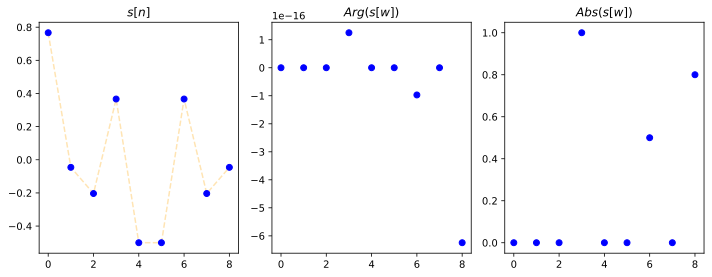

In [19]:
def plot_012(Sn):
    N = len(Sn)
    M = 1 / np.sqrt(N) * np.exp(-1j * 2 * np.pi / N * np.arange(N)[:, None] * np.arange(N)[None, :])
    
    sn = Sn @ M.conjugate()

    fig, axes = plt.subplots(1, 3, figsize=(10, 4))
    axes[0].plot(sn, '--', color='orange', alpha=0.3)
    axes[0].plot(sn, 'o', color='blue')
    
    phase, magnitude = np.angle(sn @ M), np.absolute(sn @ M)
    phase[magnitude < 1e-10] = 0
    magnitude[magnitude < 1e-10] = 0
    
    axes[1].plot(phase, 'o', color='blue')
    axes[2].plot(magnitude, 'o', color='blue')
    
    axes[0].set_title(r'$s[n]$')
    axes[1].set_title(r'$Arg(s[w])$')
    axes[2].set_title(r'$Abs(s[w])$')
    
    fig.tight_layout()
    plt.show()
    
plot_012(np.array([0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.5, 0.0, 0.8]))